# Mask R-CNN - Inspect Category Trained Model

In [81]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 配置环境

In [82]:
%cd /content/drive/MyDrive/mask rcnn_test
!pip uninstall tensorflow --yes
!pip uninstall PyYAML --yes
!pip install -r requirements.txt

/content/drive/MyDrive/mask rcnn_test
Found existing installation: PyYAML 5.4.1
Uninstalling PyYAML-5.4.1:
  Successfully uninstalled PyYAML-5.4.1
  Using cached PyYAML-5.4.1-cp37-cp37m-manylinux1_x86_64.whl (636 kB)


In [83]:
!pip list

Package                       Version
----------------------------- --------------
absl-py                       0.12.0
alabaster                     0.7.12
albumentations                0.1.12
altair                        4.1.0
appdirs                       1.4.4
argcomplete                   1.12.3
argon2-cffi                   21.1.0
arviz                         0.11.2
astor                         0.8.1
astropy                       4.3.1
astunparse                    1.6.3
atari-py                      0.2.9
atomicwrites                  1.4.0
attrs                         21.2.0
audioread                     2.1.9
autograd                      1.3
Babel                         2.9.1
backcall                      0.2.0
beautifulsoup4                4.6.3
bleach                        4.0.0
blis                          0.4.1
bokeh                         2.3.3
Bottleneck                    1.3.2
branca                        0.4.2
bs4                           0.0.1
CacheControl

In [4]:
%cd /content/drive/MyDrive/mask rcnn_test

/content/drive/MyDrive/mask rcnn_test


Import module

In [5]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt
import cv2
import time
from PIL import Image
import yaml
import tensorflow as tf
from mrcnn.config import Config
from datetime import datetime 
# Root directory of the project
ROOT_DIR = os.getcwd()

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log
from mrcnn.visualize import display_images


%matplotlib inline  
# !其实%matplotlib inline这一句是IPython的魔法函数，可以在IPython编译器里直接使用，作用是内嵌画图，省略掉plt.show()这一步，直接显示图像。
# !如果不加这一句的话，我们在画图结束之后需要加上plt.show()才可以显示图像。


Using TensorFlow backend.


In [6]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
MODEL_WEIGHT = '/content/drive/MyDrive/mask rcnn_test/logs/mask_rcnn_rock.h5'
# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "./final_detection_rock_dataset/imgs")

In [7]:
class CTRockConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # 给配置一个可识别的名字
    NAME = "rock"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (16, 32, 64,128 ,256)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE =100

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 50


In [8]:
class InferenceConfig(CTRockConfig):
    # 将批处理大小设置为1，因为我们每次只对一个图像运行推断。批量大小= GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1   # 每次在一个图像上进行预测

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.75
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES

In [9]:
# Device to load the neural network on.加载神经网络的设备。
# 如果你在同一台机器上训练一个模型，在这种情况下使用CPU，离开GPU进行训练。
DEVICE = "/cpu:0"  #TODO:  change DEVICE /cpu:0 or /gpu:0

# 在训练或推理模式中检查模型
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [10]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## 加载验证数据集

In [11]:
class CTRockDataset(utils.Dataset):
    # 得到该图中有多少个实例（物体）
    def get_obj_index(self, image):
        n = np.max(image)
        return n

    # 解析labelme中得到的yaml文件，从而得到mask每一层对应的实例标签
    def from_yaml_get_class(self, image_id):
        info = self.image_info[image_id]
        with open(info['yaml_path']) as f:
            temp = yaml.load(f.read(), Loader=yaml.FullLoader)
            labels = temp['label_names']
            del labels[0]
        return labels

    # 重新写draw_mask
    def draw_mask(self, num_obj, mask, image, image_id):
        info = self.image_info[image_id]
        for index in range(num_obj):
            for i in range(np.shape(mask)[1]):
                for j in range(np.shape(mask)[0]):
                    at_pixel = image.getpixel((i, j))
                    if at_pixel == index + 1:
                        mask[j, i, index] =1
        return mask

    # 重新写load_shapes，里面包含自己的自己的类别
    # self.add_class("shapes", 1, "category1") 
    #并在self.image_info信息中添加了path、mask_path 、yaml_path
    def load_shapes(self, count, img_floder, mask_floder, imglist, yaml_floder):
        
        # TODO=======================需修改========================
        self.add_class("shapes", 1, "rock") 
        # self.add_class("shapes", 2, "category2") 
        # TODO=========================需修改======================
        
        for i in range(count):
            img = imglist[i]
            if img.endswith(".jpg"):
                img_name = img.split(".")[0]
                img_path = img_floder + img
                mask_path = mask_floder + img_name + ".png"
                yaml_path = yaml_floder + img_name + ".yaml"
                self.add_image("shapes", image_id=i, path=img_path, mask_path=mask_path,yaml_path=yaml_path)
    
    # 重写load_mask
    def load_mask(self, image_id):
        info = self.image_info[image_id]
        img = Image.open(info['mask_path'])
        num_obj = self.get_obj_index(img)
        mask = np.zeros([np.shape(img)[0], np.shape(img)[1], num_obj], dtype=np.uint8)
        mask = self.draw_mask(num_obj, mask, img, image_id)
        labels=[]
        labels=self.from_yaml_get_class(image_id)
        labels_form=[]

        # TODO=========================需修改======================
        for i in range(len(labels)):
            if labels[i].find("rock")!=-1:
                labels_form.append("rock")
            # elif labels[i].find("category2")!=-1:
            #     labels_form.append("category2")
        # TODo=========================需修改======================
        
        class_ids = np.array([self.class_names.index(s) for s in labels_form])
        return mask, class_ids.astype(np.int32)

In [12]:
# 基础设置
dataset_root_path="final_detection_rock_dataset/"
img_floder = dataset_root_path + "imgs/"
mask_floder = dataset_root_path + "mask/"
yaml_floder = dataset_root_path + "yaml/"
imglist = os.listdir(img_floder)
count = len(imglist)


In [13]:
dataset = CTRockDataset()
dataset.load_shapes(count, img_floder, mask_floder, imglist, yaml_floder)
dataset.prepare()
print("dataset-->",dataset._image_ids)
print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

dataset--> [0 1 2 3 4 5 6 7 8 9]
Image Count: 10
Class Count: 2
  0. BG                                                
  1. rock                                              


## 载入模型

In [14]:
# 创建inference模式的mask rcnn模型
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)
# 记载训练好的权重
print("Loading weights ", MODEL_WEIGHT)
model.load_weights(MODEL_WEIGHT, by_name=True)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.cast instead.
Loading weights  /content/drive/MyDrive/mask rcnn_test/logs/mask_rcnn_rock.h5


## 预测

image ID: shapes.3 (3) 
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32
gt_class_id              shape: (8,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (8, 4)                min:   79.00000  max:  478.00000  int32
gt_mask                  shape: (512, 512, 8)         min:    0.00000  max:    1.00000  uint8


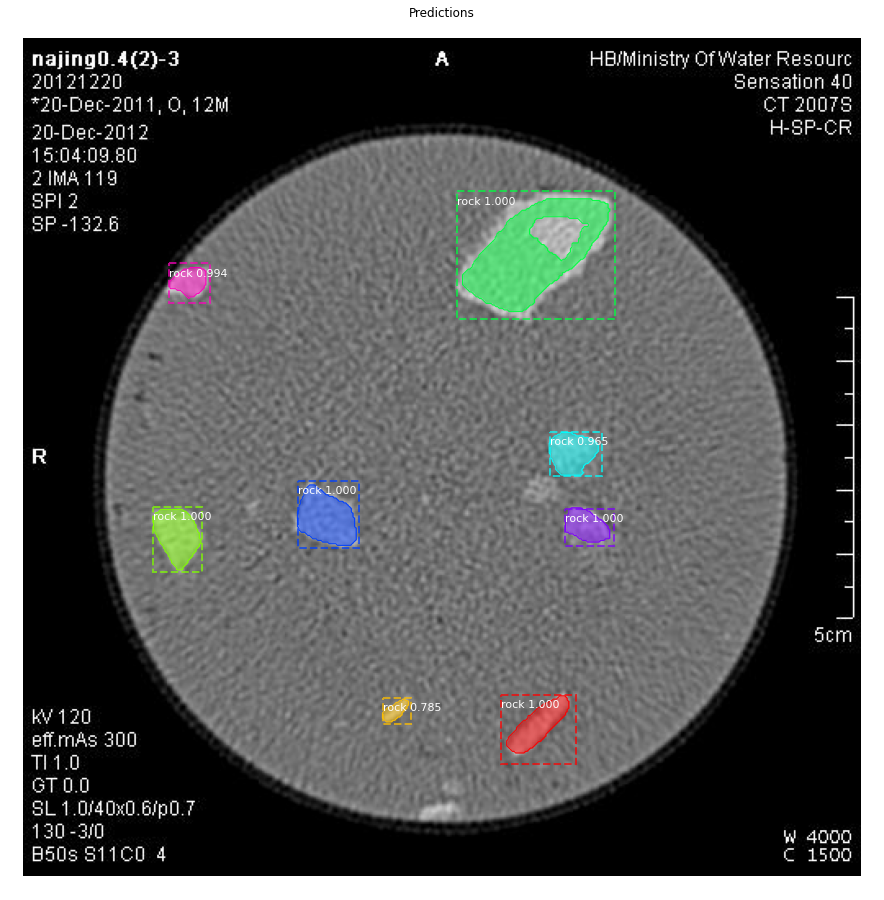

In [15]:
# 随机选取一张图片
image_id = random.choice(dataset.image_ids)
# 加载并返回图像(图像，mask，包围框)的真实数据。
# 预测时不使用mini mask
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
# info中存放有关图片的信息：weight,height,dataset_name,pic,mask,yaml
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))

# 运行预测
results = model.detect([image], verbose=1)

# 展示结果
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

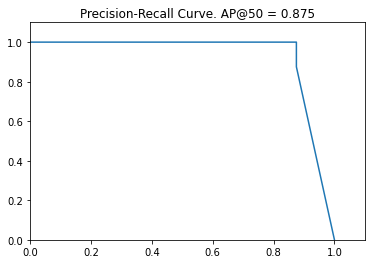

In [16]:
# Draw precision-recall curve
AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                          r['rois'], r['class_ids'], r['scores'], r['masks'])
visualize.plot_precision_recall(AP, precisions, recalls)

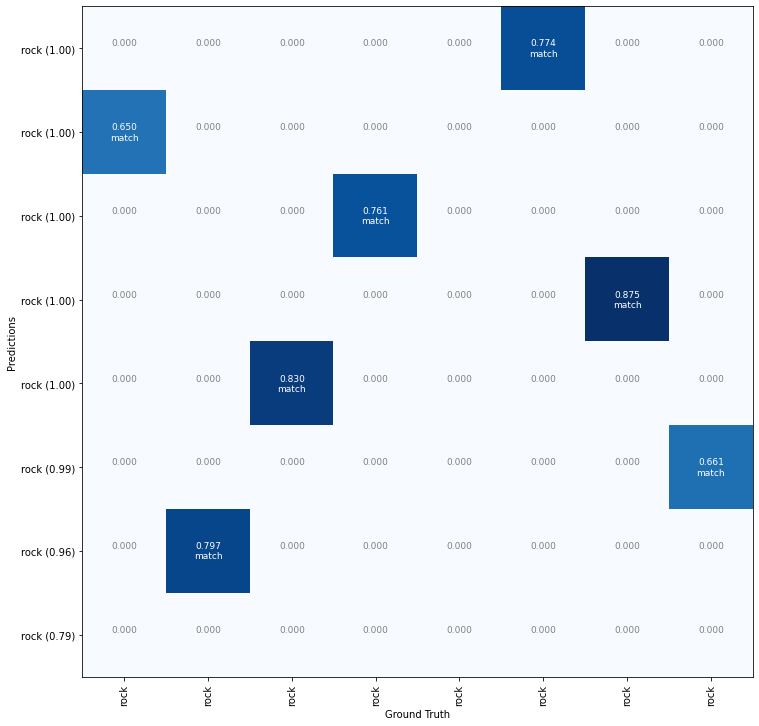

In [17]:
# Grid of ground truth objects and their predictions
visualize.plot_overlaps(gt_class_id, r['class_ids'], r['scores'],
                        overlaps, dataset.class_names)

## Color Splash

这是为了举例说明。你可以使用“splash”选项调用“balloon.py”来获得没有黑色填充的更好的图像。

In [98]:
def color_splash(image, mask):
    """Apply color splash effect.
    image: RGB image [height, width, 3]
    mask: instance segmentation mask [height, width, instance count]

    Returns result image.
    """
    # Make a grayscale copy of the image. The grayscale copy still
    # has 3 RGB channels, though.
    gray = skimage.color.gray2rgb(skimage.color.rgb2gray(image)) * 255
    # Copy color pixels from the original color image where mask is set
    if mask.shape[-1] > 0:
        # We're treating all instances as one, so collapse the mask into one layer
        mask = (np.sum(mask, -1, keepdims=True) >= 1)
        splash = np.where(mask, image, gray).astype(np.uint8)
    else:
        splash = gray.astype(np.uint8)
    return splash


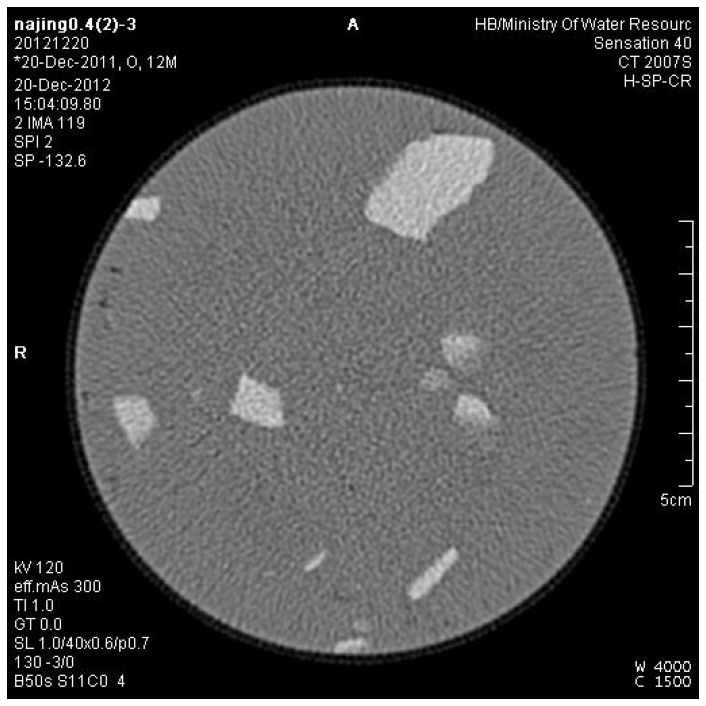

In [99]:
# 这里效果不明显
splash = color_splash(image, r['masks'])
display_images([splash], cols=1)

## 阶段一：Region Proposal Network (RPN)

Region Proposal Network(RPN)在图像上的许多边界框(建议框)上运行轻量级的二分类器，并返回关于有对象/无对象的得分。客观性得分高的建议框(正样本)被传递到第二阶段进行分类。
通常，即使是正样本也不能完全覆盖对象。因此，RPN也会回归一个改进量(位置和大小的增量或者说偏移量)，以应用到建议框，以移动它，并调整它的大小，使之成为正确的对象边界。

## 预测的详细步骤

### 1. a RPN Targets

RPN目标是RPN的训练值。在生成目标的过程中，我们首先从覆盖整个图像的不同尺寸的建议框网格开始，然后用真实对象计算建议框的IoU。(**IoU**就是：两个框的相交部分面积/相并部分面积)

- 正样本是那些IoU &gt;= 0.7，并且覆盖有任何一个真实对象。

- 负样本是那些没有覆盖任何对象并且IoU &lt; 0.3的建议框。

- 在两者之间的建议框(即IoU &gt;= 0.3但&lt;0.7)被认为是中立的，并被排除在训练之外。

为了训练RPN回归器，我们还计算了使建议框完全覆盖真实对象所需的位移和调整大小。

In [18]:
# Generate RPN trainig targets
# target_rpn_match 为1是正样本，-1是负样本 ，0 是中立样本
# target_rpn_bbox 为边界框的x1,y1,x2,y2
target_rpn_match, target_rpn_bbox = modellib.build_rpn_targets(
    image.shape, model.anchors, gt_class_id, gt_bbox, model.config)
log("target_rpn_match", target_rpn_match)
log("target_rpn_bbox", target_rpn_bbox)
# 索引
positive_anchor_ix = np.where(target_rpn_match[:] == 1)[0]
negative_anchor_ix = np.where(target_rpn_match[:] == -1)[0]
neutral_anchor_ix = np.where(target_rpn_match[:] == 0)[0]
# 坐标
positive_anchors = model.anchors[positive_anchor_ix]
negative_anchors = model.anchors[negative_anchor_ix]
neutral_anchors = model.anchors[neutral_anchor_ix]

log("positive_anchors", positive_anchors)
log("negative_anchors", negative_anchors)
log("neutral anchors", neutral_anchors)

# 将改进量应用于正样本，使之更加接近真实边界框
# target_rpn_bbox[:positive_anchors.shape[0]] 表示取出所有的目标边界框的坐标，堆叠成数组
refined_anchors = utils.apply_box_deltas(
    positive_anchors,
    target_rpn_bbox[:positive_anchors.shape[0]] * model.config.RPN_BBOX_STD_DEV)
log("refined_anchors", refined_anchors, )

target_rpn_match         shape: (65472,)              min:   -1.00000  max:    1.00000  int32
target_rpn_bbox          shape: (256, 4)              min:   -2.22507  max:    1.92206  float64
positive_anchors         shape: (9, 4)                min:   73.37258  max:  477.65685  float64
negative_anchors         shape: (247, 4)              min:  -13.25483  max:  570.50967  float64
neutral anchors          shape: (65216, 4)            min: -181.01934  max:  629.01934  float64
refined_anchors          shape: (9, 4)                min:   79.00000  max:  478.00000  float32


In [19]:
target_rpn_bbox[:positive_anchors.shape[0]] * model.config.RPN_BBOX_STD_DEV

array([[ 0.04419417,  0.        , -0.02811986,  0.13893423],
       [-0.11048543,  0.08838835, -0.17472333, -0.34657359],
       [-0.03125   ,  0.03125   , -0.20763936, -0.13353139],
       [ 0.109375  ,  0.015625  ,  0.29546421,  0.29546421],
       [ 0.        ,  0.03314563, -0.02811986, -0.44501366],
       [ 0.109375  , -0.03125   ,  0.24783616,  0.        ],
       [-0.140625  , -0.03125   ,  0.24783616,  0.        ],
       [ 0.125     ,  0.125     ,  0.17185026,  0.06062462],
       [ 0.078125  ,  0.140625  ,  0.22314355,  0.3844117 ]])

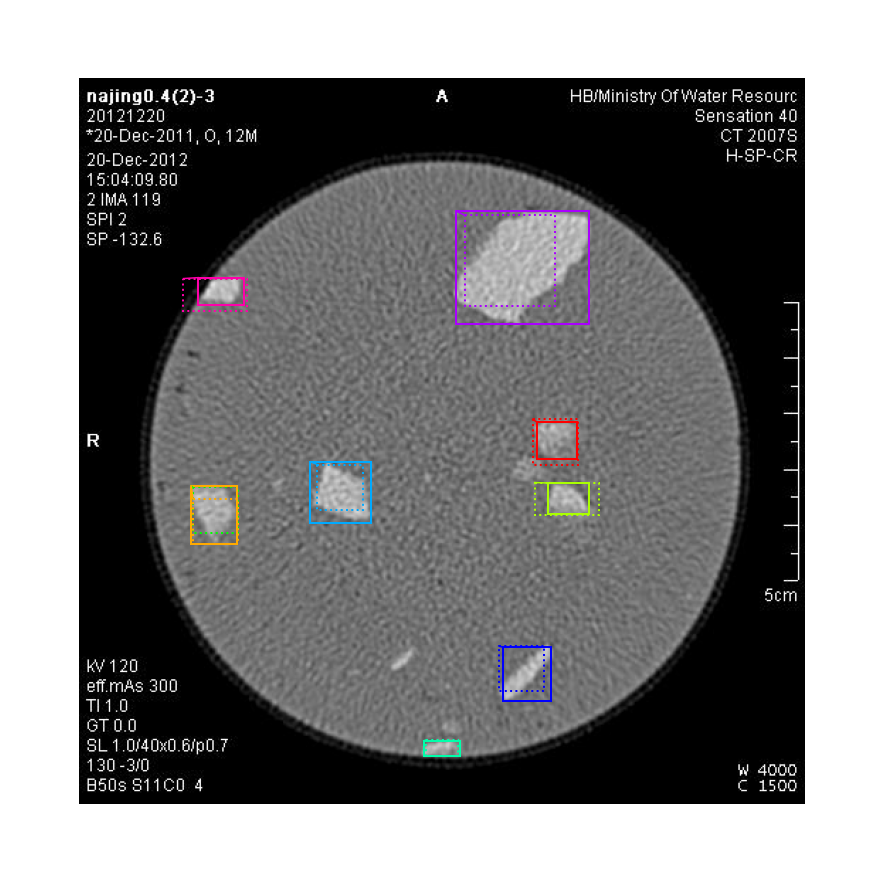

In [20]:
# Display positive anchors before refinement (dotted) and after refinement (solid).
visualize.draw_boxes(image, boxes=positive_anchors, refined_boxes=refined_anchors, ax=get_ax())

### 1.b RPN Predictions

这里我们运行RPN图并显示它的预测。

**BUG**:

`inspect_model.ipynb`的 `###1.b RPN Prediction`部分，`run_graph()`报错`AssertionError`
```
# Run RPN sub-graph
pillar = model.keras_model.get_layer("ROI").output  # node to start searching from
rpn = model.run_graph([image], [
    ("rpn_class", model.keras_model.get_layer("rpn_class").output),
    ("pre_nms_anchors", model.ancestor(pillar, "ROI/pre_nms_anchors:0")),
    ("refined_anchors", model.ancestor(pillar, "ROI/refined_anchors:0")),
    ("refined_anchors_clipped", model.ancestor(pillar, "ROI/refined_anchors_clipped:0")),
    ("post_nms_anchor_ix", model.ancestor(pillar, "ROI/rpn_non_max_suppression:0")),
    ("proposals", model.keras_model.get_layer("ROI").output),
])
```
====>
```
AssertionError            Traceback (most recent call last)
<ipython-input-14-799ca4676404> in <module>()
      7     ("refined_anchors_clipped", model.ancestor(pillar, "ROI/refined_anchors_clipped:0")),
      8     ("post_nms_anchor_ix", model.ancestor(pillar, "ROI/rpn_non_max_suppression:0")),
----> 9     ("proposals", model.keras_model.get_layer("ROI").output),
     10 ])

/home/orestisz/repositories/Mask_RCNN/model.py in run_graph(self, images, outputs)
   2296         for o in outputs.values():
   2297             print(o)
-> 2298             assert o is not None
   2299 
   2300         # Build a Keras function to run parts of the computation graph

AssertionError:

```
**解决：**

TensorFlow 1.4引入了一个新版本的NMS(No-max-suppression)操作，并使用了一个新名称。

学会在github上找issue：[run_graph  AssertionError ](https://github.com/matterport/Mask_RCNN/issues?q=run_graph++AssertionError)

- [Working with a more recent Tensorflow version #941 说是版本问题](https://github.com/matterport/Mask_RCNN/issues/941)
- [AssertionError in run_graph #23 成功解决,我用这个](https://github.com/matterport/Mask_RCNN/issues/23)
- [AssertionError when I run inspect_model.py #893 也能解决](https://github.com/matterport/Mask_RCNN/issues/893)
- [make it compatible with TF 1.9~1.10, fix bugs 官方采用 接issue#893](https://github.com/matterport/Mask_RCNN/commit/c61909a392e5f124e756140903aa34c093e95cfb)

In [56]:
# Run RPN sub-graph
pillar = model.keras_model.get_layer("ROI").output  # node to start searching from

# TF 1.4 introduces a new version of NMS. Search for both names to support TF 1.3 and 1.4
# TF 1.4 and 1.9 introduces a new version of NMS. Search for all names to support TF 1.3~1.10
# nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression:0")
# if nms_node is None:
#     nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV2:0")

# if nms_node is None: #TF 1.9-1.10
#     nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV3:0")

nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression:0")
if nms_node is None:
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV2:0")
if nms_node is None:
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV3:0")




rpn = model.run_graph([image], [
    ("rpn_class", model.keras_model.get_layer("rpn_class").output),
    ("pre_nms_anchors", model.ancestor(pillar, "ROI/pre_nms_anchors:0")),
    ("refined_anchors", model.ancestor(pillar, "ROI/refined_anchors:0")),
    ("refined_anchors_clipped", model.ancestor(pillar, "ROI/refined_anchors_clipped:0")),
    ("post_nms_anchor_ix", nms_node),
    ("proposals", model.keras_model.get_layer("ROI").output)])

rpn_class                shape: (1, 65472, 2)         min:    0.00000  max:    1.00000  float32
pre_nms_anchors          shape: (1, 6000, 4)          min:   -0.35425  max:    1.22900  float32
refined_anchors          shape: (1, 6000, 4)          min:   -2.46018  max:    3.36263  float32
refined_anchors_clipped  shape: (1, 6000, 4)          min:    0.00000  max:    1.00000  float32
post_nms_anchor_ix       shape: (1000,)               min:    0.00000  max: 2139.00000  int32
proposals                shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32


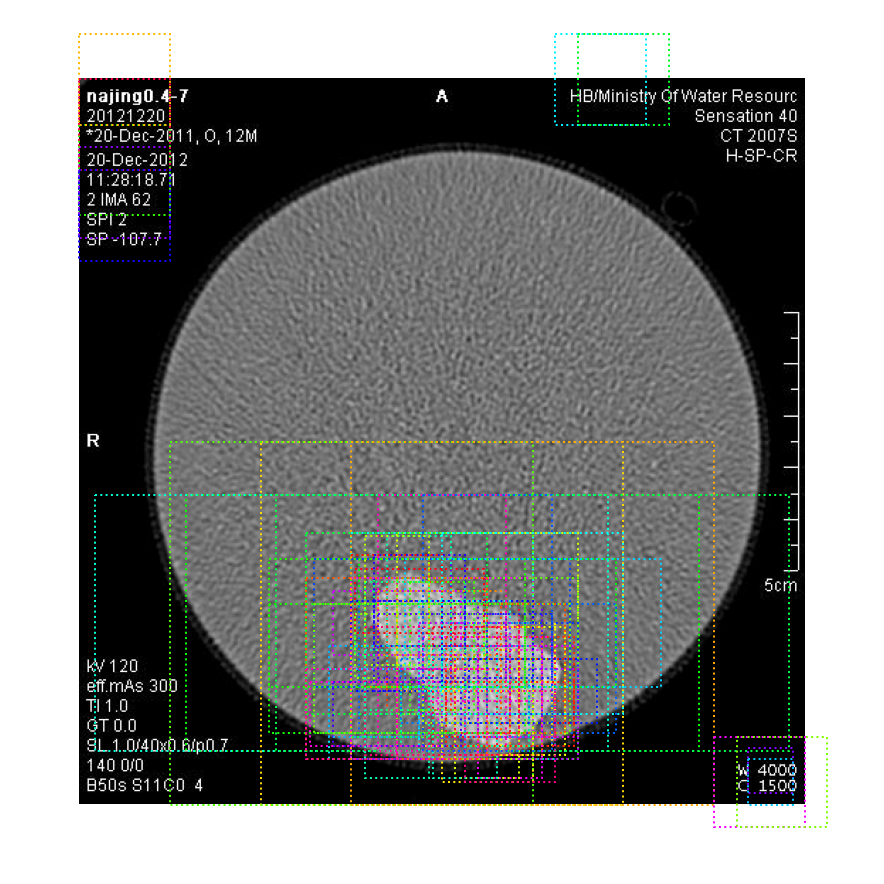

In [57]:
# 显示得分最高的建议框（未进行优化）
limit = 100
sorted_anchor_ids = np.argsort(rpn['rpn_class'][:,:,1].flatten())[::-1]
# 可视化边界框
visualize.draw_boxes(image, boxes=model.anchors[sorted_anchor_ids[:limit]], ax=get_ax())

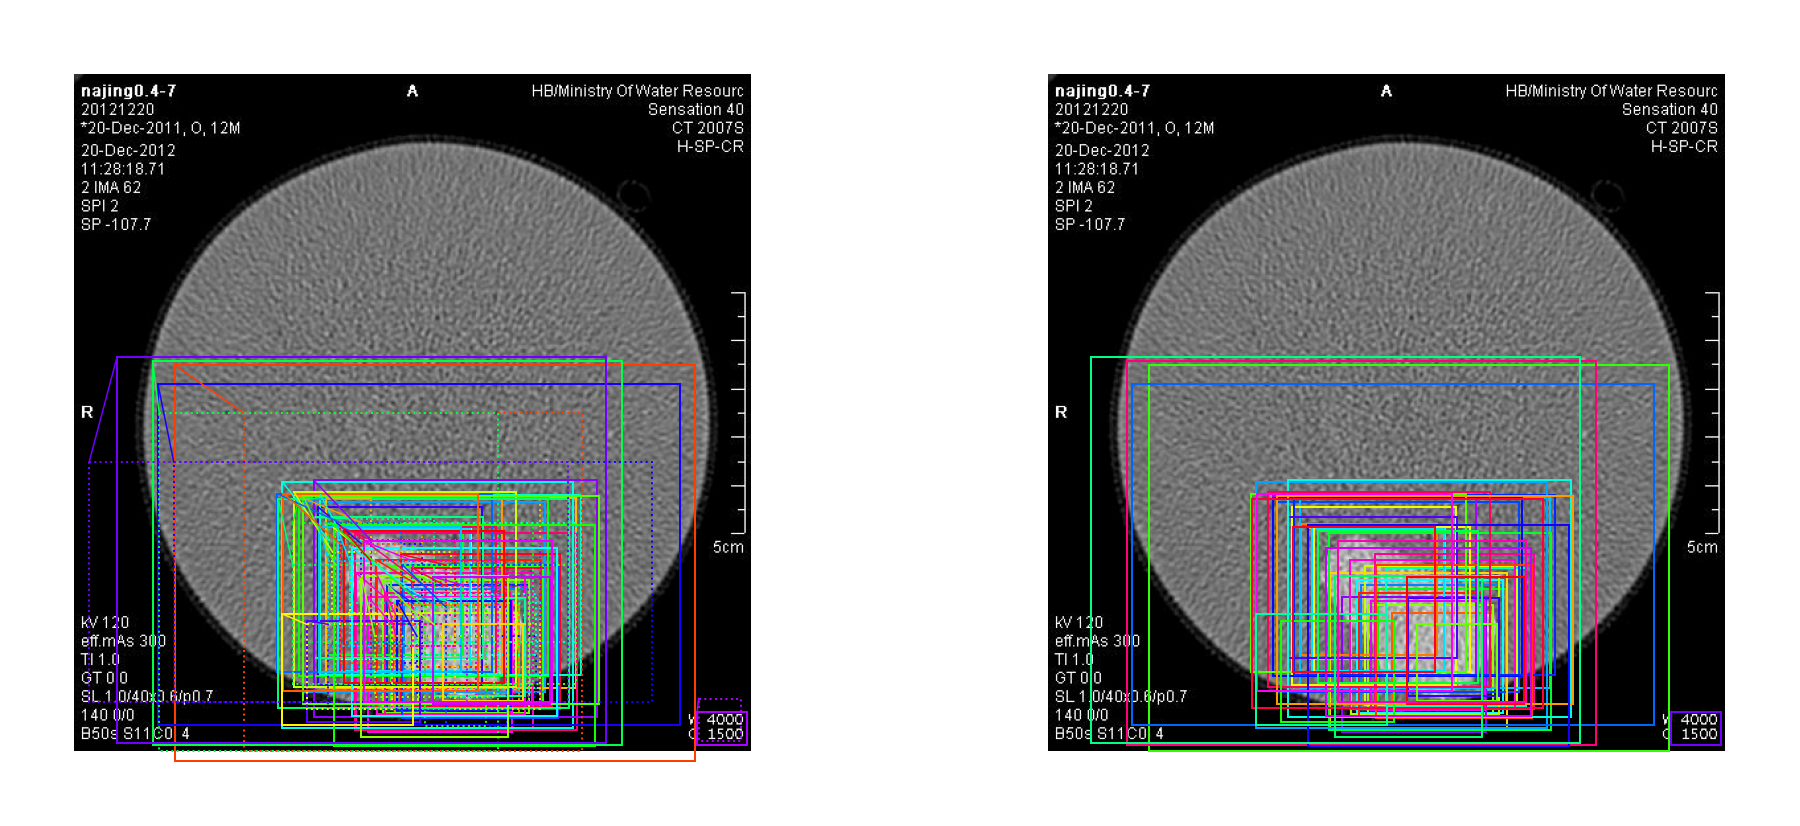

In [58]:
# Show top anchors with refinement. Then with clipping to image boundaries
# 显示经过优化改进的得分最高的边界框。然后用剪贴到图像边界
limit = 50
ax = get_ax(1, 2)

pre_nms_anchors = utils.denorm_boxes(rpn["pre_nms_anchors"][0], image.shape[:2])
refined_anchors = utils.denorm_boxes(rpn["refined_anchors"][0], image.shape[:2])
refined_anchors_clipped = utils.denorm_boxes(rpn["refined_anchors_clipped"][0], image.shape[:2])
visualize.draw_boxes(image, boxes=pre_nms_anchors[:limit],
                     refined_boxes=refined_anchors[:limit], ax=ax[0])
visualize.draw_boxes(image, refined_boxes=refined_anchors_clipped[:limit], ax=ax[1])


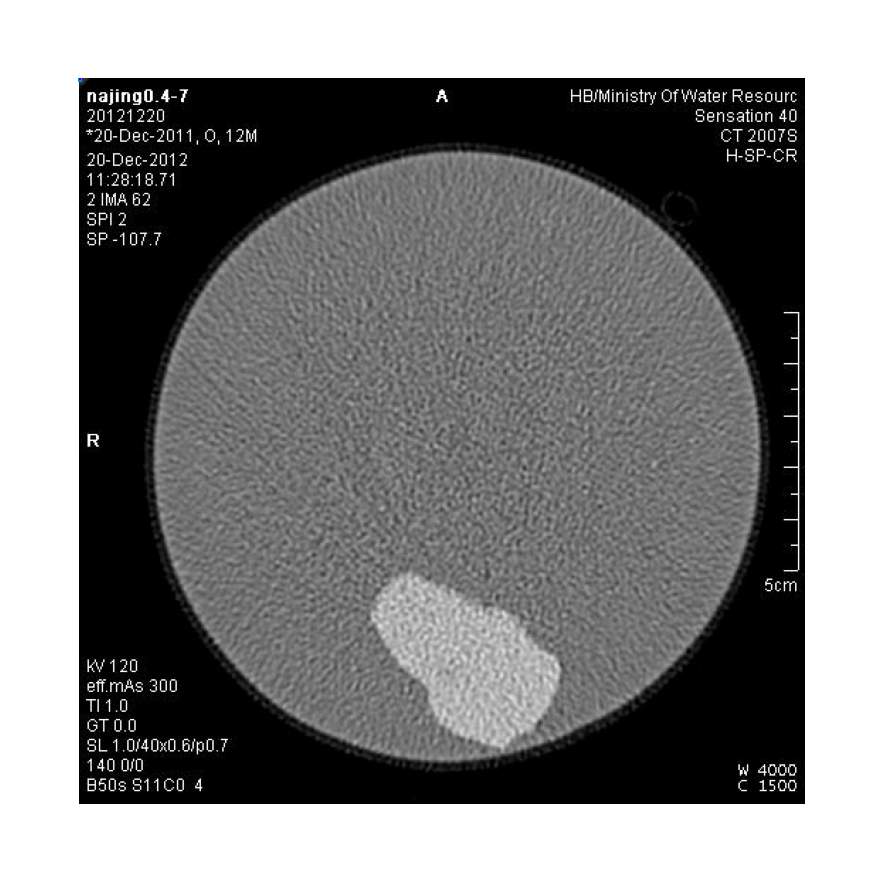

In [59]:
# 非极大值抑制后再经过改进优化
limit = 50
ixs = rpn["post_nms_anchor_ix"][:limit]
visualize.draw_boxes(image, refined_boxes=rpn["refined_anchors_clipped"][0, ixs], ax=get_ax())
# visualize.draw_boxes(image, refined_boxes=refined_anchors_clipped[ixs], ax=get_ax())

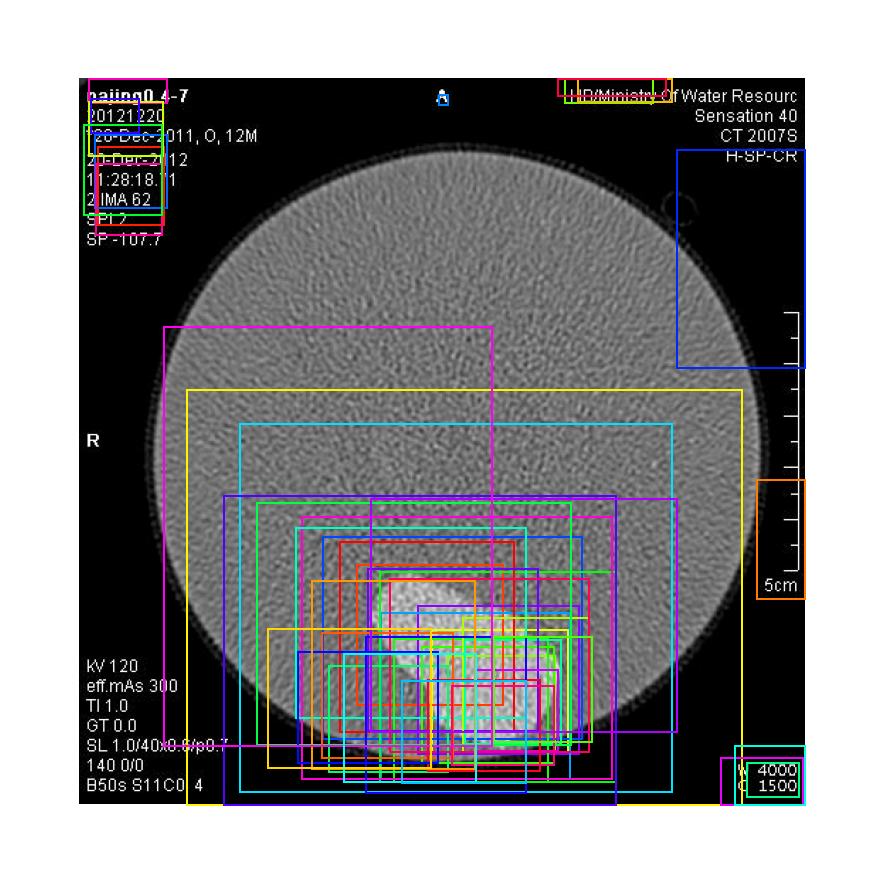

In [60]:
# 显示最后的建议框
# 这与上一步(在NMS之后细化建议框)相同，但坐标归一化到[0,1]范围。
limit = 50
# 转换回图像坐标显示
h, w = config.IMAGE_SHAPE[:2]
proposals = rpn['proposals'][0, :limit] * np.array([h, w, h, w])
visualize.draw_boxes(image, refined_boxes=proposals, ax=get_ax())

## 阶段二： Proposal Classification

这个阶段从RPN中提取区域proposal并对它们进行分类。

### 2.a Proposal Classification

根据proposal运行分类器heads以生成类别概率和边界框回归。

In [28]:
# Get input and output to classifier and mask heads.
mrcnn = model.run_graph([image], [
    ("proposals", model.keras_model.get_layer("ROI").output),
    ("probs", model.keras_model.get_layer("mrcnn_class").output),
    ("deltas", model.keras_model.get_layer("mrcnn_bbox").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
])

proposals                shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32
probs                    shape: (1, 1000, 2)          min:    0.00000  max:    1.00000  float32
deltas                   shape: (1, 1000, 2, 4)       min:   -4.18454  max:    4.56900  float32
masks                    shape: (1, 100, 28, 28, 2)   min:    0.00000  max:    1.00000  float32
detections               shape: (1, 100, 6)           min:    0.00000  max:    1.00000  float32


8 detections: ['rock' 'rock' 'rock' 'rock' 'rock' 'rock' 'rock' 'rock']


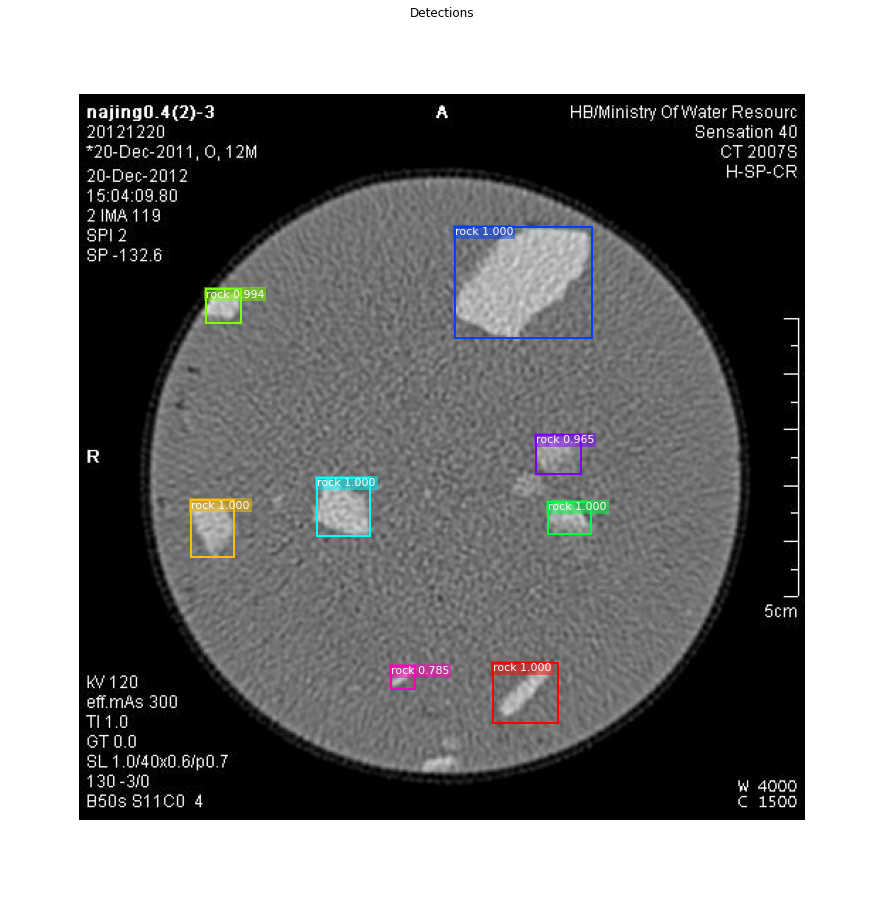

In [29]:
# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]
detections = mrcnn['detections'][0, :det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

captions = ["{} {:.3f}".format(dataset.class_names[int(c)], s) if c > 0 else ""
            for c, s in zip(detections[:, 4], detections[:, 5])]
visualize.draw_boxes(
    image, 
    refined_boxes=utils.denorm_boxes(detections[:, :4], image.shape[:2]),
    visibilities=[2] * len(detections),
    captions=captions, title="Detections",
    ax=get_ax())

### 2.c Step by Step Detection

在这里，我们深入研究处理检测的过程

In [33]:
# Proposals are in normalized coordinates. Scale them
# to image coordinates.
h, w = config.IMAGE_SHAPE[:2]
proposals = np.around(mrcnn["proposals"][0] * np.array([h, w, h, w])).astype(np.int32)

# Class ID, score, and mask per proposal
roi_class_ids = np.argmax(mrcnn["probs"][0], axis=1)
roi_scores = mrcnn["probs"][0, np.arange(roi_class_ids.shape[0]), roi_class_ids]
roi_class_names = np.array(dataset.class_names)[roi_class_ids]
roi_positive_ixs = np.where(roi_class_ids > 0)[0]

# How many ROIs vs empty rows?
print("{} Valid proposals out of {}".format(np.sum(np.any(proposals, axis=1)), proposals.shape[0]))
print("{} Positive ROIs".format(len(roi_positive_ixs)))

# Class counts
print(list(zip(*np.unique(roi_class_names, return_counts=True))))

1000 Valid proposals out of 1000
64 Positive ROIs
[('BG', 936), ('rock', 64)]


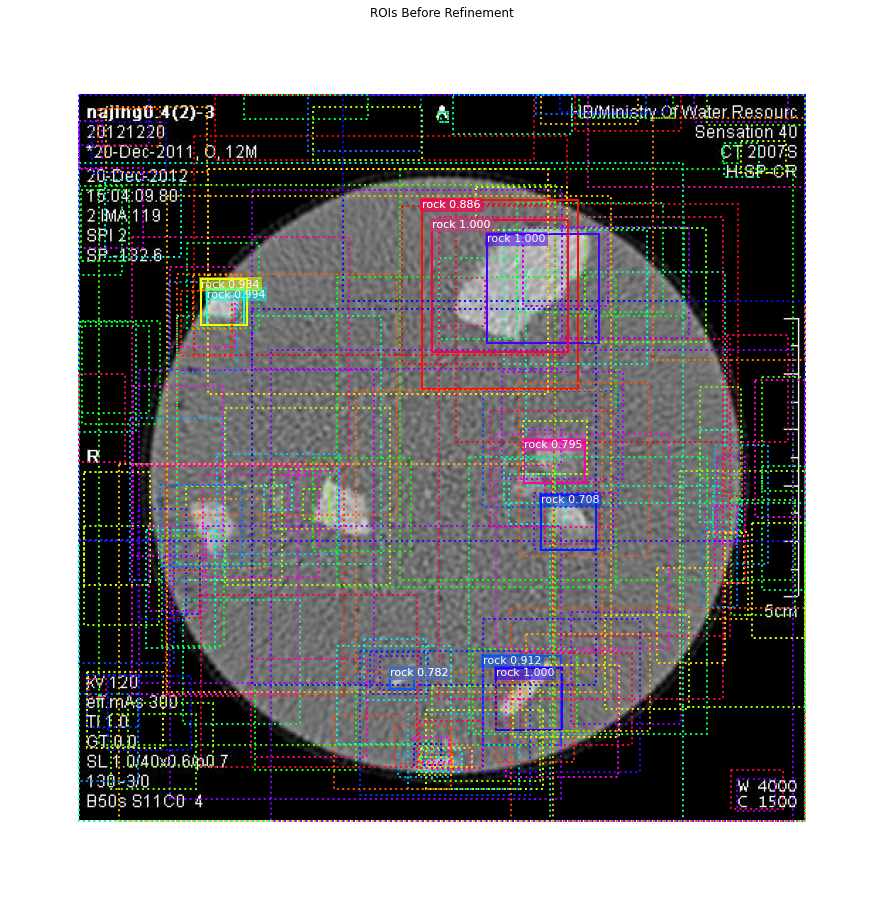

In [34]:
# Display a random sample of proposals.
# Proposals classified as background are dotted, and
# the rest show their class and confidence score.
limit = 200
ixs = np.random.randint(0, proposals.shape[0], limit)
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[ixs], roi_scores[ixs])]
visualize.draw_boxes(image, boxes=proposals[ixs],
                     visibilities=np.where(roi_class_ids[ixs] > 0, 2, 1),
                     captions=captions, title="ROIs Before Refinement",
                     ax=get_ax())

#### 边界框优化

roi_bbox_specific        shape: (1000, 4)             min:   -2.73970  max:    3.11400  float32
refined_proposals        shape: (1000, 4)             min:  -56.00000  max:  617.00000  int32


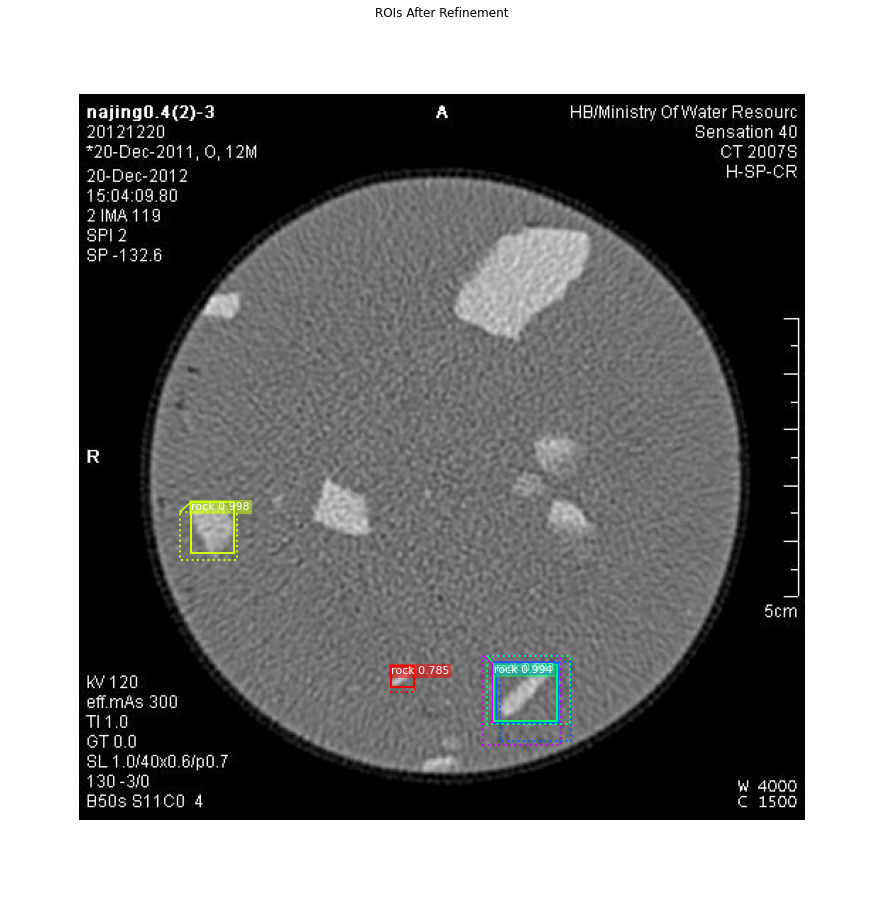

In [35]:
# Class-specific bounding box shifts.
roi_bbox_specific = mrcnn["deltas"][0, np.arange(proposals.shape[0]), roi_class_ids]
log("roi_bbox_specific", roi_bbox_specific)

# Apply bounding box transformations
# Shape: [N, (y1, x1, y2, x2)]
refined_proposals = utils.apply_box_deltas(
    proposals, roi_bbox_specific * config.BBOX_STD_DEV).astype(np.int32)
log("refined_proposals", refined_proposals)

# Show positive proposals
# ids = np.arange(roi_boxes.shape[0])  # Display all
limit = 5
ids = np.random.randint(0, len(roi_positive_ixs), limit)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[roi_positive_ixs][ids], roi_scores[roi_positive_ixs][ids])]
visualize.draw_boxes(image, boxes=proposals[roi_positive_ixs][ids],
                     refined_boxes=refined_proposals[roi_positive_ixs][ids],
                     visibilities=np.where(roi_class_ids[roi_positive_ixs][ids] > 0, 1, 0),
                     captions=captions, title="ROIs After Refinement",
                     ax=get_ax())

#### 过滤低置信度预测

In [36]:
# Remove boxes classified as background
keep = np.where(roi_class_ids > 0)[0]
print("Keep {} detections:\n{}".format(keep.shape[0], keep))

Keep 64 detections:
[  0   1   2   3   4   5   6   7   8   9  10  11  13  14  18  19  21  24
  25  26  27  35  39  40  41  44  45  46  47  48  49  54  59  75  77  80
  85 100 109 110 140 152 158 163 187 234 249 289 329 330 331 333 348 413
 432 450 462 539 619 713 783 823 898 945]


In [37]:
# Remove low confidence detections
keep = np.intersect1d(keep, np.where(roi_scores >= config.DETECTION_MIN_CONFIDENCE)[0])
print("Remove boxes below {} confidence. Keep {}:\n{}".format(
    config.DETECTION_MIN_CONFIDENCE, keep.shape[0], keep))

Remove boxes below 0.75 confidence. Keep 52:
[  0   1   2   3   4   5   7   8   9  10  11  13  14  18  19  21  25  26
  27  35  39  40  41  44  45  46  48  49  54  59  75  77  80 109 110 140
 152 158 163 249 289 329 331 333 432 450 462 619 713 823 898 945]


#### 对每个类别 非极大抑制

In [38]:
# Apply per-class non-max suppression
pre_nms_boxes = refined_proposals[keep]
pre_nms_scores = roi_scores[keep]
pre_nms_class_ids = roi_class_ids[keep]

nms_keep = []
for class_id in np.unique(pre_nms_class_ids):
    # Pick detections of this class
    ixs = np.where(pre_nms_class_ids == class_id)[0]
    # Apply NMS
    class_keep = utils.non_max_suppression(pre_nms_boxes[ixs], 
                                            pre_nms_scores[ixs],
                                            config.DETECTION_NMS_THRESHOLD)
    # Map indicies
    class_keep = keep[ixs[class_keep]]
    nms_keep = np.union1d(nms_keep, class_keep)
    print("{:22}: {} -> {}".format(dataset.class_names[class_id][:20], 
                                   keep[ixs], class_keep))

keep = np.intersect1d(keep, nms_keep).astype(np.int32)
print("\nKept after per-class NMS: {}\n{}".format(keep.shape[0], keep))

rock                  : [  0   1   2   3   4   5   7   8   9  10  11  13  14  18  19  21  25  26
  27  35  39  40  41  44  45  46  48  49  54  59  75  77  80 109 110 140
 152 158 163 249 289 329 331 333 432 450 462 619 713 823 898 945] -> [  0   1   7   3   2   9 333 619]

Kept after per-class NMS: 8
[  0   1   2   3   7   9 333 619]


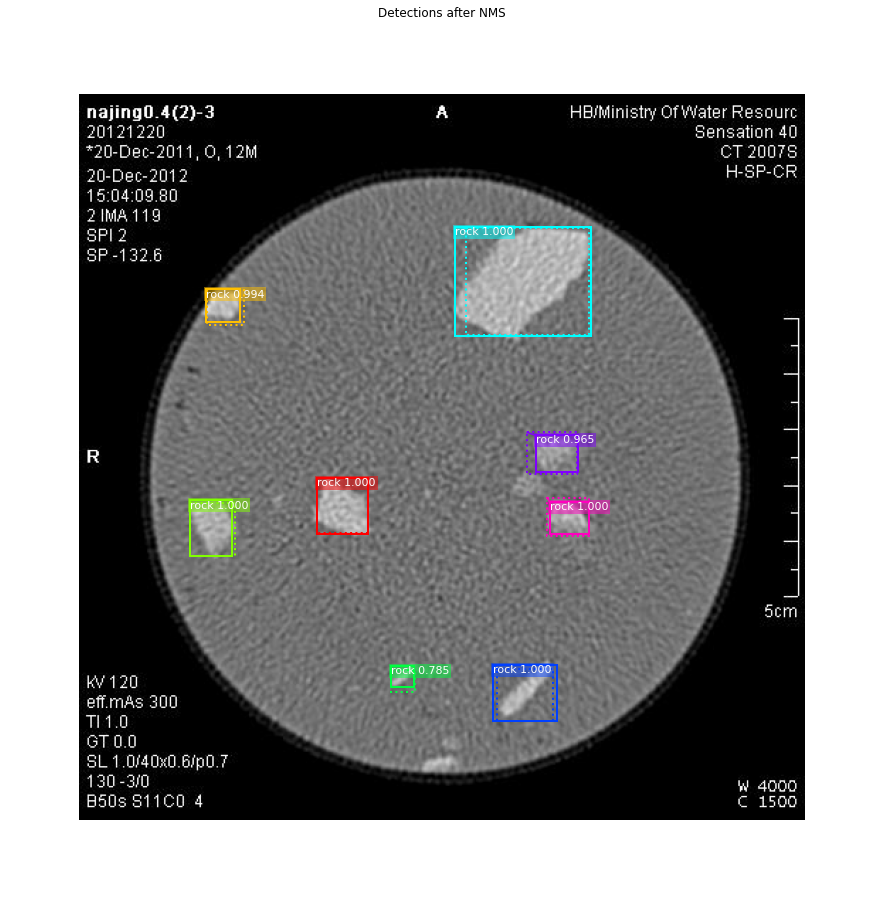

In [39]:
# Show final detections
ixs = np.arange(len(keep))  # Display all
# ixs = np.random.randint(0, len(keep), 10)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[keep][ixs], roi_scores[keep][ixs])]
visualize.draw_boxes(
    image, boxes=proposals[keep][ixs],
    refined_boxes=refined_proposals[keep][ixs],
    visibilities=np.where(roi_class_ids[keep][ixs] > 0, 1, 0),
    captions=captions, title="Detections after NMS",
    ax=get_ax())

## 阶段三： 生成mask掩码

这个阶段从之前的网络层获取检测结果(优化后的边界框和类别id)，并运行mask head为每个实例生成分割掩码。

### 3.a Mask Targets

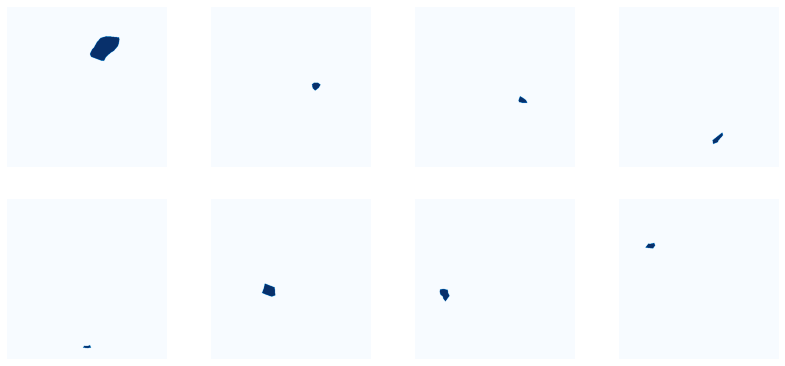

In [40]:
display_images(np.transpose(gt_mask, [2, 0, 1]), cmap="Blues")

### 3.b Predicted Masks

In [41]:
# Get predictions of mask head
mrcnn = model.run_graph([image], [
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
])

# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

detections               shape: (1, 100, 6)           min:    0.00000  max:    1.00000  float32
masks                    shape: (1, 100, 28, 28, 2)   min:    0.00000  max:    1.00000  float32
8 detections: ['rock' 'rock' 'rock' 'rock' 'rock' 'rock' 'rock' 'rock']


In [42]:
# Masks
det_boxes = utils.denorm_boxes(mrcnn["detections"][0, :, :4], image.shape[:2])
det_mask_specific = np.array([mrcnn["masks"][0, i, :, :, c] 
                              for i, c in enumerate(det_class_ids)])
det_masks = np.array([utils.unmold_mask(m, det_boxes[i], image.shape)
                      for i, m in enumerate(det_mask_specific)])
log("det_mask_specific", det_mask_specific)
log("det_masks", det_masks)

det_mask_specific        shape: (8, 28, 28)           min:    0.00000  max:    1.00000  float32
det_masks                shape: (8, 512, 512)         min:    0.00000  max:    1.00000  bool


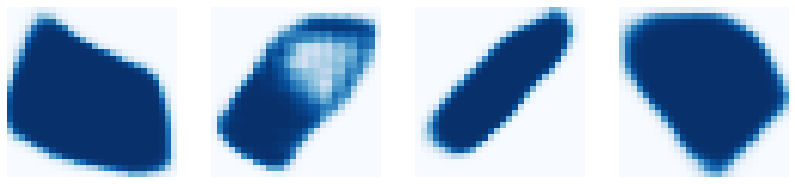

In [43]:
display_images(det_mask_specific[:4] * 255, cmap="Blues", interpolation="none")

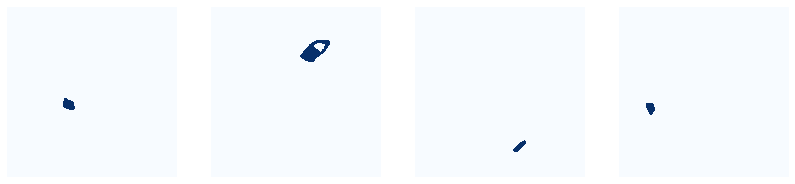

In [44]:
display_images(det_masks[:4] * 255, cmap="Blues", interpolation="none")


## Visualize Activations

在某些情况下，查看来自不同层的输出并将其可视化以捕获问题和奇怪的模式会有所帮助。

In [45]:
model.keras_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_image (InputLayer)         (None, None, None, 3) 0                                            
____________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D) (None, None, None, 3) 0           input_image[0][0]                
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, None, None, 64 9472        zero_padding2d_1[0][0]           
____________________________________________________________________________________________________
bn_conv1 (BatchNorm)             (None, None, None, 64 256         conv1[0][0]                      
___________________________________________________________________________________________

In [46]:
# Get activations of a few sample layers
activations = model.run_graph([image], [
    ("input_image",        model.keras_model.get_layer("input_image").output),
    ("res2c_out",          model.keras_model.get_layer("res2c_out").output),
    ("res3c_out",          model.keras_model.get_layer("res3c_out").output),
    ("res4w_out",          model.keras_model.get_layer("res4f_out").output),  # for resnet100
    ("rpn_bbox",           model.keras_model.get_layer("rpn_bbox").output),
    ("roi",                model.keras_model.get_layer("ROI").output),
])

input_image              shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10001  float32
res2c_out                shape: (1, 128, 128, 256)    min:    0.00000  max:   54.78692  float32
res3c_out                shape: (1, 64, 64, 512)      min:    0.00000  max:   47.63832  float32
res4w_out                shape: (1, 32, 32, 1024)     min:    0.00000  max:   37.70437  float32
rpn_bbox                 shape: (1, 65472, 4)         min:  -10.17268  max:   24.38069  float32
roi                      shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32


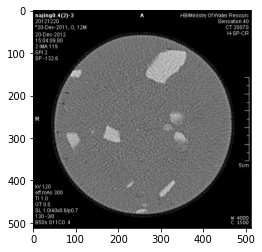

In [47]:
# Input image (normalized)
_ = plt.imshow(modellib.unmold_image(activations["input_image"][0],config))

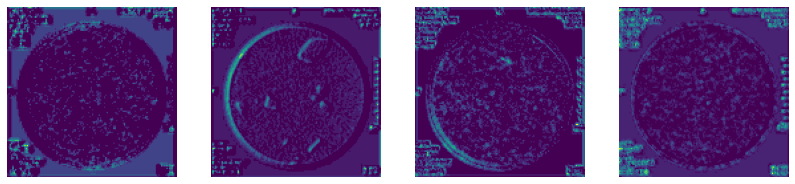

In [48]:
# Backbone feature map
display_images(np.transpose(activations["res2c_out"][0,:,:,:4], [2, 0, 1]), cols=4)

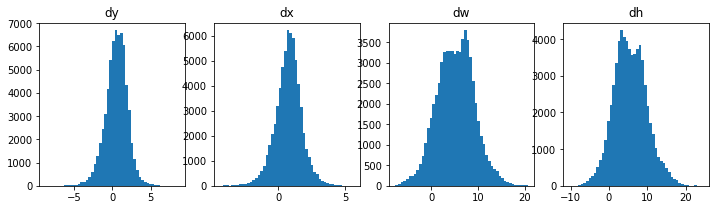

In [49]:
# Histograms of RPN bounding box deltas
plt.figure(figsize=(12, 3))
plt.subplot(1, 4, 1)
plt.title("dy")
_ = plt.hist(activations["rpn_bbox"][0,:,0], 50)
plt.subplot(1, 4, 2)
plt.title("dx")
_ = plt.hist(activations["rpn_bbox"][0,:,1], 50)
plt.subplot(1, 4, 3)
plt.title("dw")
_ = plt.hist(activations["rpn_bbox"][0,:,2], 50)
plt.subplot(1, 4, 4)
plt.title("dh")
_ = plt.hist(activations["rpn_bbox"][0,:,3], 50)

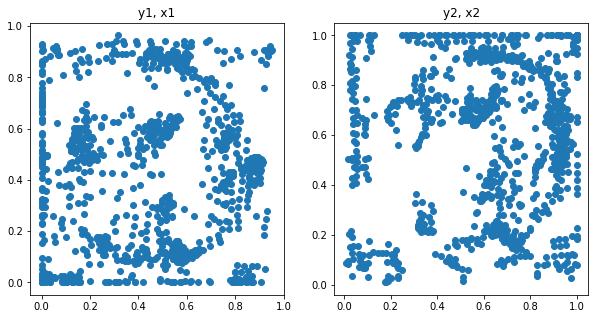

In [51]:
# Distribution of y, x coordinates of generated proposals
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("y1, x1")
plt.scatter(activations["roi"][0,:,0], activations["roi"][0,:,1])
plt.subplot(1, 2, 2)
plt.title("y2, x2")
plt.scatter(activations["roi"][0,:,2], activations["roi"][0,:,3])
plt.show()

### 预测单张图像

In [50]:
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'Bt']
# Load a random image from the images folder
file_names = next(os.walk(IMAGE_DIR))[2]
image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))


Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32
time: 8
{'rois': array([[349, 207, 473, 339]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.99803346], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
 

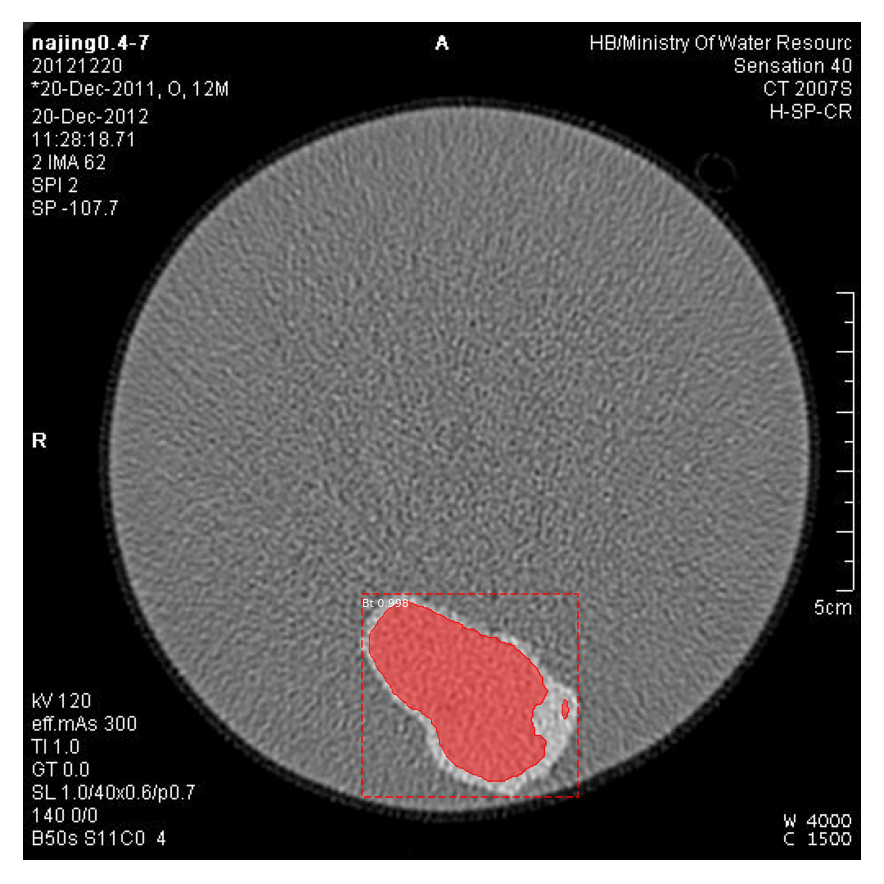

In [52]:
a=datetime.now() 
# Run detection
results = model.detect([image], verbose=1)
b=datetime.now() 
# Visualize results
print("time:",(b-a).seconds)
r = results[0]
print (r)
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])
